# Modeling

In [425]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import product
from collections import defaultdict
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import sys
sys.path.append("../model")
from model import get_data
from pipeline import Pipeline
import constants as C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [525]:
# taken from churn case study solution
def plot_feature_importances(df, feature_importances):
    feat_scores = pd.DataFrame({'Mean Decrease Impurity' : feature_importances},
                           index=KEEP)
    feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
    feat_scores.plot(kind='barh', figsize=(8,8))

In [427]:
# stolen from sklearn's example
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ["Finished", "Cancelled"], rotation=45)
    plt.yticks(np.arange(2), ["Finished", "Cancelled"])
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [482]:
def get_past_ride_cnt(df, y):
    ride_history = []
    for i, user_id in enumerate(df["user_id"]):
        ride_history.append(d[user_id].copy())
        if y is not None:
            d[user_id].append(y[i])
    return ride_history

def change_datetimes(df, *args):
    for col_name in args:
        df[col_name] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df[col_name], 'D')
    return df

def calculate_time_between(df, **kwargs):
    for k, (v1, v2) in kwargs.items():
        df[k] = (df[v1] - df[v2]).dt.total_seconds() / 86400
    return df

In [471]:
pipeline = Pipeline()
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

### Read data

In [592]:
engine = create_engine(C.ENGINE)
df = get_data(engine)
df["current_state"] = ((df["current_state"] != "finished") & (df["current_state"] != "started")).astype(int)
y = df.pop("current_state").values
y_mean = y.mean()

In [ ]:
df.shape

In [593]:
d = defaultdict(list)
df_temp = df.copy()
df_temp["rides"] = get_past_ride_cnt(df_temp, y)
df_temp["past_rides"] = df_temp["rides"].apply(lambda lst: len(lst))
df_temp["past_cancellations"] = df_temp["rides"].apply(lambda lst: sum(lst))
df_temp["past_percent_cancelled"] = df_temp["past_cancellations"] / df_temp["past_rides"]
df_temp["past_percent_cancelled"] = df_temp["past_percent_cancelled"].fillna(y_mean)

df_temp = change_datetimes(df_temp, "pickup", "dropoff", "created_at")
df_temp = calculate_time_between(df_temp, days_to_pickup=("pickup", "created_at"), trip_duration=("dropoff", "pickup"))
df_temp["weekend_pickup"] = df_temp["pickup"].dt.dayofweek.isin([4, 5, 6]).astype(int)
df_temp["weekend_created"] = df_temp["created_at"].dt.dayofweek.isin([4, 5, 6]).astype(int)
df_temp["arizona_or_nevada"] = df_temp["in_state"].isin(["Arizona", "Nevada"]).astype(int)

df_temp["used_promo"] = df_temp["promo_code_id"].notnull().astype(int)
df_temp["used_referral"] = df_temp["referral_code"].notnull().astype(int)
df_temp["credit_card"] = df_temp["postal_code"].notnull().astype(int)
df_temp["web_booking"] = (df_temp["booking_application"] == "web").astype(int)
df_temp["new_customer"] = (df_temp["reservation_frequency"] != "repeat_customer").astype(int)
df_temp["modified_profile"] = (df_temp["updated_at"] > df_temp["created_at_user"])

In [594]:
KEEP = ["created_as_guest", "local_rental", "awards_referral_bonus", "is_gds_user",
        "insurance_corporate", "insurance_personal", "insurance_silvercar", "days_to_pickup",
        "trip_duration", "weekend_pickup", "winter_pickup", "used_promo", "used_referral",
        "credit_card", "web_booking", "new_customer", "past_rides", "past_cancellations",
        "past_percent_cancelled", "pickup_dow", "arizona_or_nevada", "modified_profile"]
df_temp = df_temp[KEEP].fillna(0)

In [595]:
X_train, X_test, y_train, y_test = train_test_split(df_temp, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [596]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy: {}".format(model.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.780292207507647
Precision: 0.84651968503937
Recall: 0.5709763766145479


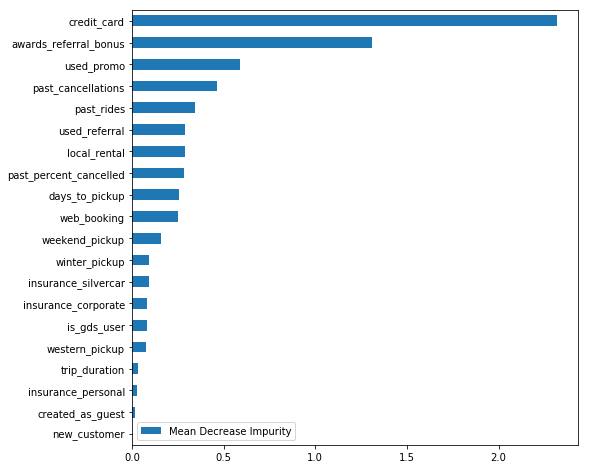

In [597]:
plot_feature_importances(X_train, np.abs(model.coef_[0]))

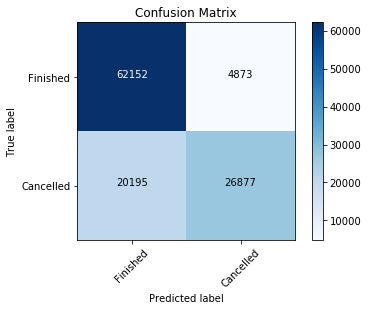

In [598]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [599]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy: {}".format(model.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7681972356854255
Precision: 0.7609972158947103
Recall: 0.6387449014276003


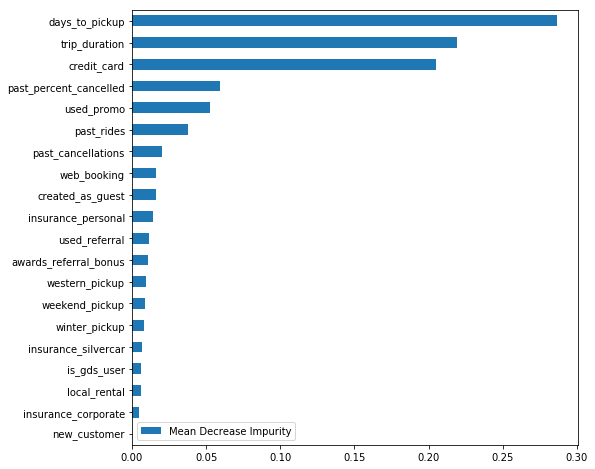

In [600]:
plot_feature_importances(df, model.feature_importances_)

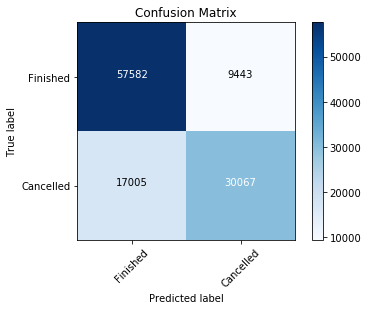

In [601]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [510]:
gbc = GradientBoostingClassifier(n_estimators=20, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [511]:
gbc.score(X_test, y_test)

0.78828540627711507